In [1]:
import pandas as pd
import numpy as np

Now that we have imported the required libraries, we start by loading the necessary dataframes.

In [2]:
df_disp_name_key = pd.read_csv("/kaggle/input/precogdata/csv/keys/keys/disp_name_key.csv")
df_states = pd.read_csv("/kaggle/input/precogdata/csv/keys/keys/cases_state_key.csv")
years = [i for i in range(2010, 2019)]

These were the files that can be used while completely in memory efficiently. For the cases by year files, we will need to chunk them and work with one chunk at a time.

In [3]:
%%time     

#counter_variables
states_guilty = {}
states_total = {}

for i in range(1, 34):
    states_guilty[i] = 0
    states_total[i] = 0
    
for year in years:

    print(f"\n{year}")
    df_year = pd.read_csv(f"/kaggle/input/precogdata/csv/cases/cases/cases_{year}.csv", low_memory=True, chunksize=100_000, iterator=True)
    
    for sub_year in df_year:

        df_merged = pd.merge(
            left = sub_year, 
            right = df_disp_name_key, 
            left_on ="disp_name", 
            right_on ="disp_name",
            how = "inner")
        
        # keeping only the relevant columns
        convicted = df_merged[['disp_name_s', 'state_code']]
        
        # how many rows per state
        num_states = df_merged['state_code'].value_counts().to_dict()

        # only rows where disp is convicted remain
        convicted = convicted[convicted['disp_name_s'] == 'convicted']
        
        # how many convicted per state
        res = convicted.value_counts().to_dict()

        # increment counter variables
        for i in res:
            states_guilty[i[1]] += res[i]
        for i in num_states:
            states_total[i] += num_states[i]

        # progress bar
        print('.', end='')


2010
...........................................
2011
.....................................................
2012
.................................................................
2013
............................................................................
2014
.........................................................................................
2015
.........................................................................................................
2016
..................................................................................................................
2017
...................................................................................................................................
2018
..........................................................................................................................................CPU times: user 18min 43s, sys: 5min 58s, total: 24min 41s
Wall time: 26min 56s


In [8]:
states = {}
df_states_clean = df_states[['state_name', 'state_code']].drop_duplicates()

for ind in df_states_clean.index:
    states[df_states_clean['state_code'][ind]] = df_states_clean['state_name'][ind]

Setting up the states dictionary that tells us the state code.

In [9]:
states

{2: 'Andhra Pradesh',
 29: 'Telangana',
 6: 'Assam',
 8: 'Bihar',
 27: 'Chandigarh',
 18: 'Chhattisgarh',
 32: 'DNH at Silvasa',
 31: 'Diu and Daman',
 30: 'Goa',
 17: 'Gujarat',
 14: 'Haryana',
 5: 'Himachal Pradesh',
 33: 'Ladakh',
 12: 'Jammu and Kashmir',
 7: 'Jharkhand',
 3: 'Karnataka',
 4: 'Kerala',
 23: 'Madhya Pradesh',
 1: 'Maharashtra',
 25: 'Manipur',
 21: 'Meghalaya',
 19: 'Mizoram',
 26: 'Delhi',
 11: 'Orissa',
 22: 'Punjab',
 9: 'Rajasthan',
 24: 'Sikkim',
 10: 'Tamil Nadu',
 20: 'Tripura',
 13: 'Uttar Pradesh',
 15: 'Uttarakhand',
 16: 'West Bengal'}

Setting up the res variable that holds the conviction verdict percentage.

In [10]:
res = {}

for i in range(1, 34):
    if i == 28: continue
    res[states[i]] = states_guilty[i]*100 / states_total[i]

Glancing at the data once before plotting it.

In [13]:
for i in res:
    print(f"{i:<18}", res[i])

Maharashtra        1.1627214000333577
Andhra Pradesh     1.4626004482730128
Karnataka          5.747370192007138
Kerala             0.4956119958357799
Himachal Pradesh   0.8908018934348697
Assam              2.236685372494615
Jharkhand          0.4726664810170147
Bihar              0.06890029110483338
Rajasthan          0.40168790720461334
Tamil Nadu         4.874577390765077
Orissa             0.14869613939765203
Jammu and Kashmir  0.1569030496147706
Uttar Pradesh      1.9918911031724358
Haryana            3.9257756302285958
Uttarakhand        1.407395987049314
West Bengal        3.530750792246069
Gujarat            0.19148368993692463
Chhattisgarh       0.7336537632216533
Mizoram            13.005066909185397
Tripura            1.291766743460288
Meghalaya          0.6240753984971246
Punjab             2.9265809363451716
Madhya Pradesh     6.1545438675893775
Sikkim             1.5031196823596142
Manipur            1.2955939315687541
Delhi              0.3529900257708558
Chandigarh    

Some states' names are different in the map data, hence we update the dataframe state names, and also convert res into a dictionary.

In [14]:
st_clean = list(res.keys())
for i in range(len(st_clean)):
    if st_clean[i] == 'Tamil Nadu':
        st_clean[i] = 'Tamilnadu'
    if st_clean[i] == 'Telangana':
        st_clean[i] = 'Telengana'
    if st_clean[i] == 'Chhattisgarh':
        st_clean[i] = 'Chhattishgarh'        
    if st_clean[i] == 'Orissa':
        st_clean[i] = 'Odisha'
    if st_clean[i] == 'DNH at Silvasa':
        st_clean[i] = 'Daman and Diu and Dadra and Nagar Haveli'
        
df = pd.DataFrame({
    'states' : st_clean,
    'vals' : res.values()
})

Importing required libraries for plotting the map.

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt 

Checking which states exist on the map but we don't have data about them.

In [4]:
shp_gdf = gpd.read_file('/kaggle/input/precogdata/maps/India-State-and-Country-Shapefile-Updated-Jan-2020-master/India_State_Boundary.shp')
for i in shp_gdf['State_Name']:
    if i not in list(df['states']):
        print(i)

NameError: name 'gpd' is not defined

Combine the map data and our data.

In [ ]:
merged = pd.merge(left = shp_gdf, right = df, left_on = 'State_Name', right_on = 'states')
merged.head()

Finally, plotting the values on the map.

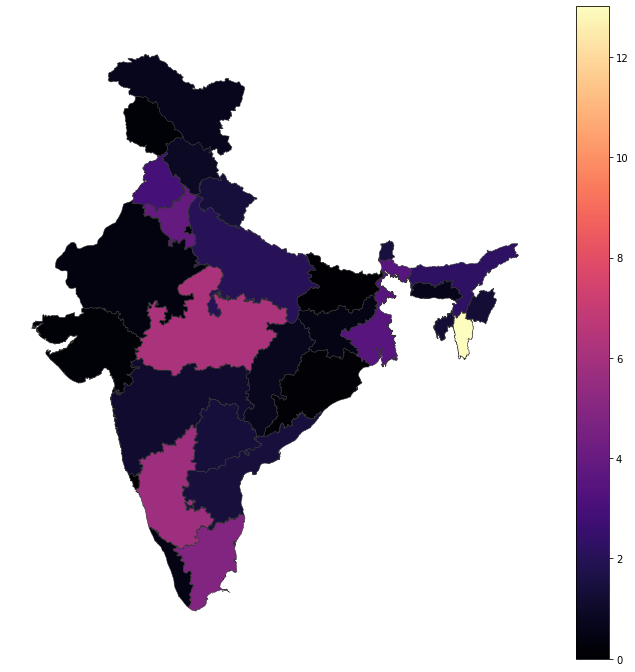

In [28]:
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
missing_kwds = dict(color='grey', label='No Data')

# gdf.plot(column='random', scheme='Quantiles', k= 5,
#          legend=True, legend_kwds=dict(loc='center left'),
#          missing_kwds=missing_kwds, ax=ax)

p = merged.plot(column='vals', cmap='magma', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True, missing_kwds=missing_kwds)


#### Here, we see that Mizoram has the highest conviction verdict, with Madhya Pradesh and Karnataka next in line but with a large gap.